In [11]:
import torch
import torch.nn as nn
import os
import numpy as np 

def normalization(data):
    return (data - min(data)) / (max(data) - min(data))

class OneDCNN(nn.Module):
    def __init__(self):
        super(OneDCNN, self).__init__()
        
        # 定义卷积层
        self.conv1 = nn.Sequential(  
                        nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(16),
                    )
        self.conv2 = nn.Sequential(  
                        nn.Conv1d(in_channels=16, out_channels=32, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(32),
                    )
        self.conv3 = nn.Sequential(  
                        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(64),
                    )
        self.conv4 = nn.Sequential(  
                        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(128),
                    )
        
        
        # 定义全连接层
        self.fc1 = nn.Linear(1024//8*64, sample_num)
        
    def forward(self, x):
        # 将输入的一维向量转化为三维张量，第一维是batch size，第二维是通道数，第三维是向量长度
        x = x.unsqueeze(1)
        x = x.to(torch.float32)
        # 第一个卷积层
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # 展开张量，用于全连接层输入
        x = torch.flatten(x, start_dim=1)
        
        # 全连接层
        x = self.fc1(x)
        
        return x

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm

# 定义数据集
class MyDataset(Dataset):
    def __init__(self, dirs, is_train, test_start = 180):
        self.x = None
        self.y = None
        for data_dir in dirs:
            f_list = os.listdir(data_dir)
            if is_train: 
                for idx in range(min(sample_num, len(f_list))):
                    if self.x is None:
                        self.x = np.load(data_dir + str(idx+1) + '.npy')[:180, :]
                    else:
                        self.x = np.concatenate((self.x, np.load(data_dir + str(idx+1) + '.npy')[:180, :]))
                    tempy = np.zeros((180, sample_num))
                    tempy[:, idx] = 1
                    if self.y is None:
                        self.y = tempy
                    else:
                        self.y = np.concatenate((self.y, tempy))
            else:
                for idx in range(min(sample_num, len(f_list))):
                    if self.x is None:
                        self.x = np.load(data_dir + str(idx+1) + '.npy')[test_start:, :]
                    else:
                        self.x = np.concatenate((self.x, np.load(data_dir + str(idx+1) + '.npy')[test_start:, :]))
                    tempy = np.zeros((20, sample_num))
                    tempy[:, idx] = 1
                    if self.y is None:
                        self.y = tempy
                    else:
                        self.y = np.concatenate((self.y, tempy))
        # print(self.y.shape)
        # print(self.y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

# 定义训练函数
def train(model, dataloader, criterion, optimizer):
    model.train()
    for x, y in dataloader:
        optimizer.zero_grad()
        output = model(x.to(device))
        loss = criterion(output, y.to(device))
        loss.backward()
        optimizer.step()

# 定义测试函数
def test(model, dataloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            output = model(x.to(device))
            test_loss += criterion(output, y.to(device)).item()
            pred = output.argmax(dim=1, keepdim=True)
            label = y.argmax(dim=1, keepdim=True)
            correct += pred.cpu().eq(label).sum().item()
    test_loss /= len(dataloader.dataset)
    accuracy = 100.0 * correct / len(dataloader.dataset)
    return test_loss, accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_num = 15
# 构建模型、优化器和损失函数
model = OneDCNN().cuda()
# print(model)
optimizer = optim.Adam(model.parameters(), lr=0.00003)
criterion = nn.CrossEntropyLoss()

# 准备数据
# train_data = np.random.rand(1000,1000)
trian_data_dir = [
                    # 'data/generated_noisy/',
                    # 'data/generated_clean/',
                    # 'data/noisy_npy/',
                    'data/clean_npy/',
                ]

train_dataset = MyDataset(trian_data_dir, True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_data_dir = [
                    # 'data/generated_noisy/',
                    # 'data/generated_clean/',
                    # 'data/noisy_npy/',
                    # 'data/clean_npy/',
                    # 'data/CNT_noisy_final/',
                    # 'data/CNT_clean/',
                    # 'data/CNT_noisy/',
                    'data/R-noisy-clean/',
                    # 'data/DnCNN-noisy-clean/',
                ]
test_dataset = MyDataset(test_data_dir, False, 0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
# for epoch in range(100):
#     with tqdm(train_loader,total = 43*100, unit="batch") as tepoch: 
#         for data, target in tepoch:              
#             tepoch.set_description(f"Epoch {epoch}") 
#             data, target = data.to(device), target.to(device)#.squeeze(1)       # Data to device
#             optimizer.zero_grad()                                              # Zero gradient 
#             output = model(data)                                               # Forward propagation
#             losstr = criterion(output, target.to(device))                           # Calculate loss
#             losstr.backward()                                                  # Back propagation
#             optimizer.step()                                                   # Optimize parameters

#             predict = output.argmax(dim=1, keepdim=True)  
#             label = target.argmax(dim=1, keepdim=True)# Get the index 
#             correct = predict.eq(label).sum().item() 

#             # model.vis_moni_train(losstr.item(),correct,model.global_step) if vis==True else None # Visulize
#             accuracy = correct/len(data)
#             tepoch.set_postfix(loss=losstr.item(), accuracy='{:.3f}'.format(accuracy)) # 🌟 4. 设置结尾

# 训练模型
for epoch in range(300):
    train(model, train_loader, criterion, optimizer)
    test_loss, accuracy = test(model, test_loader, criterion)
    if epoch % 10 == 0: 
        print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")
        
torch.save(model.state_dict(), "save/model_1DCNN.pth")

Epoch 1, Test Loss: 0.0263, Accuracy: 18.33%
Epoch 11, Test Loss: 0.0139, Accuracy: 44.00%
Epoch 21, Test Loss: 0.0154, Accuracy: 43.00%
Epoch 31, Test Loss: 0.0175, Accuracy: 53.00%
Epoch 41, Test Loss: 0.0168, Accuracy: 56.67%
Epoch 51, Test Loss: 0.0163, Accuracy: 59.00%
Epoch 61, Test Loss: 0.0197, Accuracy: 54.00%
Epoch 71, Test Loss: 0.0192, Accuracy: 52.67%
Epoch 81, Test Loss: 0.0176, Accuracy: 52.33%
Epoch 91, Test Loss: 0.0211, Accuracy: 52.33%
Epoch 101, Test Loss: 0.0213, Accuracy: 52.00%
Epoch 111, Test Loss: 0.0191, Accuracy: 51.00%
Epoch 121, Test Loss: 0.0204, Accuracy: 52.33%
Epoch 131, Test Loss: 0.0223, Accuracy: 51.33%
Epoch 141, Test Loss: 0.0212, Accuracy: 53.67%
Epoch 151, Test Loss: 0.0211, Accuracy: 52.67%
Epoch 161, Test Loss: 0.0240, Accuracy: 51.33%
Epoch 171, Test Loss: 0.0215, Accuracy: 53.33%
Epoch 181, Test Loss: 0.0242, Accuracy: 51.33%
Epoch 191, Test Loss: 0.0228, Accuracy: 52.33%
Epoch 201, Test Loss: 0.0246, Accuracy: 51.00%
Epoch 211, Test Loss: 0.

# Process raw data

In [192]:
import os
import numpy as np 
def normalization(data):
    return (data - min(data)) / (max(data) - min(data))
        
for sample_id in range(11,13):
    data_dir = str.format('data/clean_spectrum/{}/', sample_id)
    f_list = os.listdir(data_dir)
    final_data = []
    for filename in f_list:
        f = open(data_dir + filename,'r')
        if len(final_data) != 114:
            flist = []
            for line in f.readlines():
                flist.append(int(line.split('\t')[1].strip()))
            for i in range(24):
                flist.append(0)
        arr = np.array(flist)
        final_data.append(normalization(arr))
    # print(normalization(arr))
    final_arr = np.array(final_data)
    print(np.mean(final_data))
    print(np.std(final_data))
    np.save(str.format('data/clean_npy/{}', sample_id), final_arr)

0.39277944602720866
0.32627021660158617
0.39208995860537704
0.32764255673372217


# From raw npy data to smooth npy data

In [31]:
import os
import numpy as np 
f_list = os.listdir('data/clean_npy/')
for t_file in f_list:
    data = np.load(str.format('data/clean_npy/{}', t_file))
    for i in range(data.shape[0]):
        data[i] = savgol_filter(data[i], 8, 3, mode= 'nearest')

    np.save(str.format('data/smooth_clean_npy/{}', t_file), data)

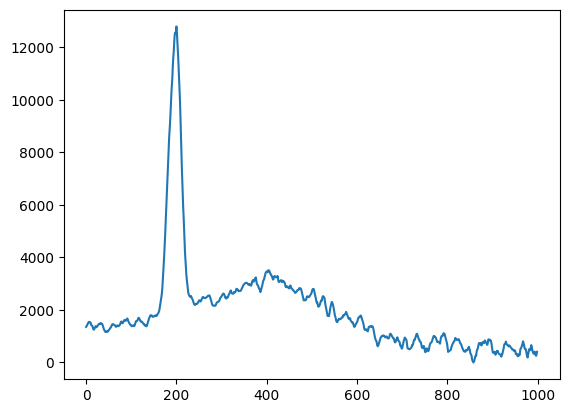

In [42]:
import matplotlib.pyplot as plt
final_arr
for i in range(200):
    plt.cla()
    plt.plot(final_arr[i])
    plt.savefig(str.format('data/figs/{}.png', i))

In [43]:
import imageio
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for i in range(188):
        image = imageio.imread(str.format('data/figs/{}.png', i))
        writer.append_data(image)

/tmp/ipykernel_625025/696923902.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(str.format('data/figs/{}.png', i))


In [52]:
!pip install tqdm

/bin/bash: /home/visitor/anaconda3/envs/1DCNN/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://mirror.baidu.com/pypi/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.4 MB/s eta 0:00:00


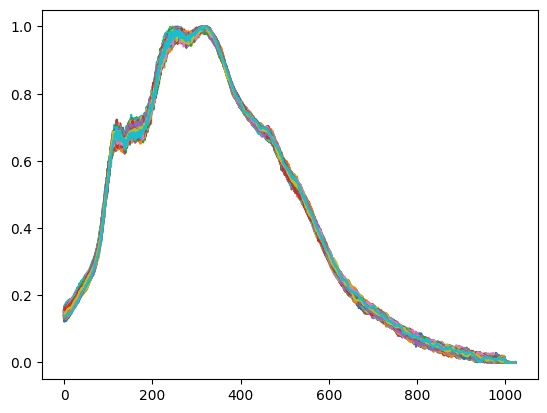

In [222]:
import os
import numpy as np 
import matplotlib.pyplot as plt
current = "15"
data = np.load("data/CNT_noisy_final/"+current+".npy")
np.save("data/CNT_noisy_final/"+current+".npy", data)
for i in range(0, 200):
    # if np.var(data[i][:200]) < 0.05:
    #     print("{}: {} and {}".format(i, np.var(data[i][:200]), np.mean(data[i][:200])))
        plt.plot(data[i])

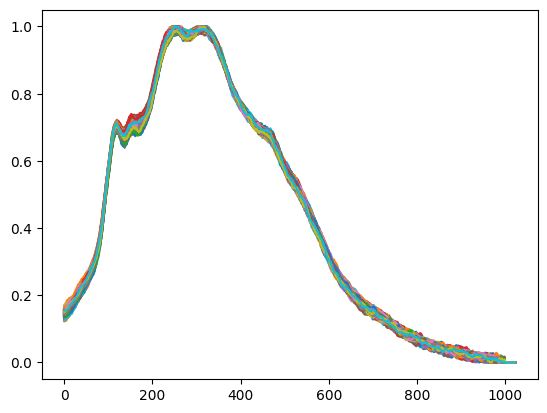

In [154]:
import os
import numpy as np 
import matplotlib.pyplot as plt
data = np.load("data/noisy_npy/15.npy")
for i in range(0,200):
    plt.plot(data[i])

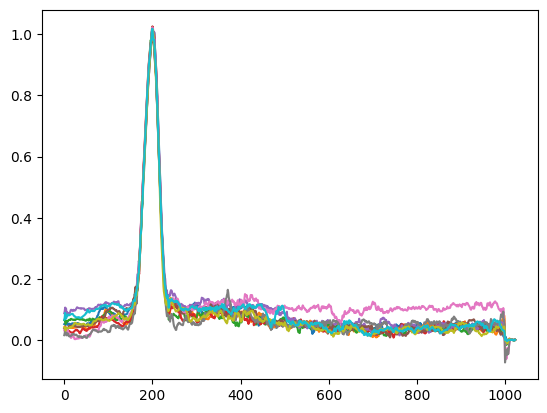

In [33]:
import os
import numpy as np 
import matplotlib.pyplot as plt
data = np.load("data/R-noisy-clean/1.npy")
for i in range(10):
    plt.plot(data[i])

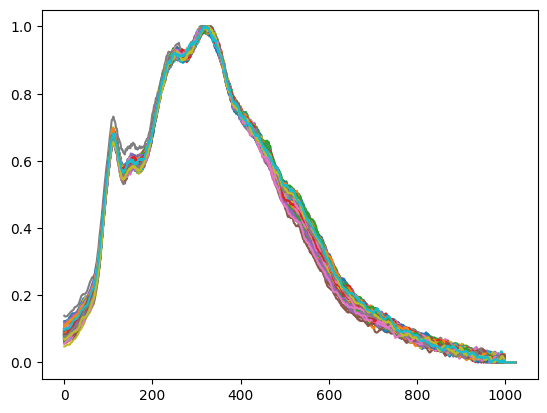

In [206]:
import os
import numpy as np 
import matplotlib.pyplot as plt
data = np.load("data/clean_npy/11.npy")
# data[100] = data[101]
np.save("data/CNT_noisy_final/11.npy", data)
for i in range(0, 200):
    plt.plot(data[i])